In [120]:
# general imports
import pandas as pd
import numpy as np
import re
import json
import itertools
# text processing
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import preprocessing

#visualization
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import HTML, display
from palettable.colorbrewer.qualitative import Pastel1_7
from scipy import stats
from scipy.stats.stats import pearsonr


In [153]:
'''
Daily values:
    Fat: less than 65g
    Cholesterol: less than 0.3g
    Sodium: less than 2.4g
    Carbs: 300g
        of which Fiber: 30g
    Protein: 50g
    Sugar: 37.5g
    
Sources:
https://www.fda.gov/food/labelingnutrition/ucm274593.htm#percent_daily_value
http://www.abc.net.au/health/library/stories/2007/04/23/1904178.htm
https://www.healthline.com/nutrition/how-much-sugar-per-day#section3

Ranking in unhealthiness
1. Cholesterol - 5
2. Sodium - 5
3. Fat - 4
4. Carbs - 3
5. Protein - 3
6. Fiber - 2
'''

'\nDaily values:\n    Fat: less than 65g\n    Cholesterol: less than 0.3g\n    Sodium: less than 2.4g\n    Carbs: 300g\n        of which Fiber: 30g\n    Protein: 50g\n    Sugar: 37.5g\n    \nSources:\nhttps://www.fda.gov/food/labelingnutrition/ucm274593.htm#percent_daily_value\nhttp://www.abc.net.au/health/library/stories/2007/04/23/1904178.htm\nhttps://www.healthline.com/nutrition/how-much-sugar-per-day#section3\n'

In [295]:
# Reading the file
full_df_original = pd.read_json('unified_data.json')
full_df_original.head(5)

,Beans and Rice,Cheese and Bread,Chemical Components,Dipping,Drinks,Fish,Fruits,Herbes,Irrelevant,Meat and Chicken,...,month,name,prep_time,protein,rating,review,servings,sodium,totalcarbs,year
0,0,2,0,0,0,0,0,0,3,1,...,12,Slow Cooker Reuben Dip,4,17.0,4,"[I, always, looking, great, crockpot, recipes,...",12.0,636.0,5.0,2005
1,0,2,0,0,0,0,0,0,3,1,...,2,Slow Cooker Reuben Dip,4,17.0,4,"[Enjoyed, recipe, I, chopped, sauerkraut, w, k...",12.0,636.0,5.0,2008
10,0,2,0,0,0,0,0,0,3,1,...,3,Slow Cooker Reuben Dip,4,17.0,4,"[This, good, I, threw, together, work, potluck...",12.0,636.0,5.0,2007
100,0,0,1,0,0,0,0,0,2,0,...,6,Asparagus Wrapped in Crisp Prosciutto,5,3.0,4,"[This, first, proscuitto, asparagus, recipe, I...",16.0,279.0,0.0,2006
1000,0,0,4,0,0,0,2,0,5,0,...,9,Samhain Pumpkin Bread,20,3.0,4,"[I, used, frozen, pumpkin, puree, didnt, quite...",16.0,261.0,32.0,2010


In [296]:
# Checking columns
full_df_original.columns

Index(['Beans and Rice', 'Cheese and Bread', 'Chemical Components', 'Dipping',
       'Drinks', 'Fish', 'Fruits', 'Herbes', 'Irrelevant', 'Meat and Chicken',
       'Pasta', 'Pastry', 'Sauces', 'Spices', 'Starch', 'Sushi', 'Vegtables',
       'calories', 'cholesterol', 'cook_time', 'day', 'fat', 'fiber', 'month',
       'name', 'prep_time', 'protein', 'rating', 'review', 'servings',
       'sodium', 'totalcarbs', 'year'],
      dtype='object')

In [297]:
# Grouping recipes together. Taking first instance of recipe and averaging the rating
full_set = full_df_original.copy()

full_set['sodium'] = full_set['sodium'].apply(lambda x: x*0.001)
full_set['cholesterol'] = full_set['cholesterol'].apply(lambda x: x*0.001)

full_set['total_time'] = full_set['prep_time'] + full_set['cook_time']
full_set_test1 = full_set.groupby('name').agg({'servings':'first','protein':'first','fat':'first','cholesterol':'first','sodium':'first','totalcarbs':'first','fiber':'first','rating':'mean'})
full_set_test1['rating'] = round(full_set_test1['rating'], 0)

In [298]:
full_set_test1['protein healthy?'] = full_set_test1['protein'] <= 25
full_set_test1['fat healthy?'] = full_set_test1['fat'] <= 32.5
full_set_test1['carbs healthy?'] = full_set_test1['fat'] <= 150
full_set_test1['cholesterol healthy?'] = full_set_test1['fat'] <= 0.15
full_set_test1['sodium healthy?'] = full_set_test1['fat'] <= 1.2
full_set_test1['fiber healthy?'] = full_set_test1['fat'] <= 15
full_set_test1['Healthy grade'] = sum([full_set_test1['protein healthy?'], full_set_test1['fat healthy?'], full_set_test1['carbs healthy?'],full_set_test1['cholesterol healthy?'], full_set_test1['sodium healthy?'], full_set_test1['fiber healthy?']])
full_set_test1.head()



,servings,protein,fat,cholesterol,sodium,totalcarbs,fiber,rating,protein healthy?,fat healthy?,carbs healthy?,cholesterol healthy?,sodium healthy?,fiber healthy?,Healthy grade
name,,,,,,,,,,,,,,,
""" Ant"" Kelly's London Broil Marinade",3.0,2.7,18.0,0.0000,1.4573,7.9,0.3,5.0,True,True,True,False,False,False,3
""" Creamy "" Vegan Potato-Leek Soup",8.0,6.5,2.0,0.0000,0.0180,35.9,5.5,3.0,True,True,True,False,False,True,4
""" Da Best"" Chicago-Style Italian Beef",7.0,67.7,39.5,0.2431,0.5177,3.2,0.4,4.0,False,False,True,False,False,False,1
""" Healthy"" Pumpkin Pie",8.0,3.9,0.1,0.0005,0.0516,5.1,0.2,4.0,True,True,True,True,True,True,6
""" Jamba Juice at Home"" Strawberries Wild Smoothie",3.0,0.6,0.3,0.0000,0.0040,19.0,1.6,5.0,True,True,True,False,True,True,5


### Healthy Grade

healthy:  0.5183910922056799
unhealthy 0.48160890779432003


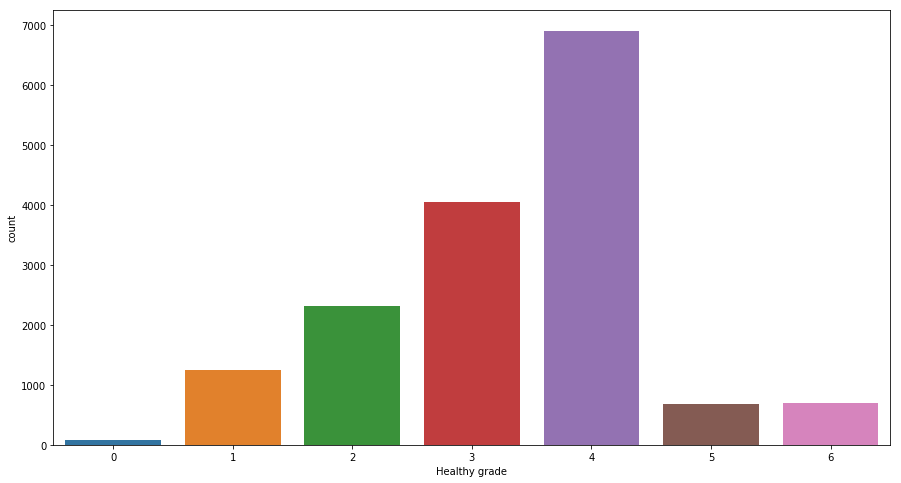

In [300]:
plt.figure(figsize=(15,8))
# full_set_test1['Healthy grade'] = full_set_test1['Healthy grade'].astype(int)
unhealthy = full_set_test1[full_set_test1['Healthy grade'] <= 3]
healthy = full_set_test1[full_set_test1['Healthy grade'] > 3]
sns.countplot(x='Healthy grade', data=full_set_test1)
print('healthy: ', healthy['Healthy grade'].count()/full_set_test1['Healthy grade'].count())
print('unhealthy', unhealthy['Healthy grade'].count()/full_set_test1['Healthy grade'].count()) 

### Number of unhealthy recipes
After establishing that recipes with 0-2 nutrients, i.e. grade 4-6, exceeding the recommended daily value are considere healthy and the ones with 3-6, i.e. below grade of 4, are considered unhealthy, we give the following analysis.

From the above graph we can conclude that the majority of the recipes exceeds only 2 of the 6 nutrients present utilized in this analysis with a health grade of 4. We can also notice that there are more unhealthier recipes (4-6 nutrients exceeding the daily value) than there are of very healthy ones (0-2 of the nutrients exceeding the daily recommended values). It can noted as well how there's a very slim number of recipes that does exceeds the daily values for each nutrient.

We can then say that a little over half of the recipes are somewhat healthy or healthy with 51% of the total amount of recipes falling into this category, while the remaining 49% can be considered healthy.

In [309]:
pearson_corr, _ = pearsonr(full_set_test1['rating'], full_set_test1['Healthy grade'])
print('Rating vs Healthy:', round(pearson_corr,3))

pearson_corr, _ = pearsonr(full_set_test1['rating'], full_set_test1['protein healthy?'])
print('Rating vs Protein:', round(pearson_corr,3))

pearson_corr, _ = pearsonr(full_set_test1['rating'], full_set_test1['fat healthy?'])
print('Rating vs Fat:', round(pearson_corr,3))

pearson_corr, _ = pearsonr(full_set_test1['rating'], full_set_test1['carbs healthy?'])
print('Rating vs Carbs:', round(pearson_corr,3))

pearson_corr, _ = pearsonr(full_set_test1['rating'], full_set_test1['cholesterol healthy?'])
print('Rating vs Cholesterol:', round(pearson_corr,3))

pearson_corr, _ = pearsonr(full_set_test1['rating'], full_set_test1['sodium healthy?'])
print('Rating vs Sodium:', round(pearson_corr,3))

pearson_corr, _ = pearsonr(full_set_test1['rating'], full_set_test1['fiber healthy?'])
print('Rating vs Fiber:', round(pearson_corr,3))

pearson_corr, _ = pearsonr(full_set_test1['protein'], full_set_test1['Healthy grade'])
print('Protein vs Healthy Grade:', round(pearson_corr,3))

pearson_corr, _ = pearsonr(full_set_test1['fat'], full_set_test1['Healthy grade'])
print('Fat vs Healthy Grade:', round(pearson_corr,3))

pearson_corr, _ = pearsonr(full_set_test1['totalcarbs'], full_set_test1['Healthy grade'])
print('Carbs vs Healthy Grade:', round(pearson_corr,3))

pearson_corr, _ = pearsonr(full_set_test1['cholesterol'], full_set_test1['Healthy grade'])
print('Cholesterol vs Healthy Grade:', round(pearson_corr,3))

pearson_corr, _ = pearsonr(full_set_test1['sodium'], full_set_test1['Healthy grade'])
print('Sodium vs Healthy Grade:', round(pearson_corr,3))

pearson_corr, _ = pearsonr(full_set_test1['fiber'], full_set_test1['Healthy grade'])
print('Fiber  vs Healthy Grade:', round(pearson_corr,3))

Rating vs Healthy: -0.038
Rating vs Protein: -0.006
Rating vs Fat: -0.026
Rating vs Carbs: 0.014
Rating vs Cholesterol: -0.0
Rating vs Sodium: -0.032
Rating vs Fiber: -0.05
Protein vs Healthy Grade: -0.609
Fat vs Healthy Grade: -0.59
Carbs vs Healthy Grade: -0.222
Cholesterol vs Healthy Grade: -0.539
Sodium vs Healthy Grade: -0.154
Fiber  vs Healthy Grade: -0.147


### Combining nutrients and health grades

In [313]:

nutri_comb_set = full_set_test1.copy()
cols = list(nutri_comb_set.columns)
cols.remove('rating')
cols.remove('protein healthy?')
cols.remove('fat healthy?')
cols.remove('carbs healthy?')
cols.remove('cholesterol healthy?')
cols.remove('sodium healthy?')
cols.remove('fiber healthy?')
cols.remove('Healthy grade')

new_comb_list = list(itertools.combinations(cols, 2))

for comb in new_comb_list:
#     print(comb)
    col = ' and '.join(comb)
    nutri_comb_set[col] = nutri_comb_set[comb[0]] *nutri_comb_set[comb[1]]
    pearson_corr, _ = pearsonr(full_set_test1['rating'], nutri_comb_set[col])
    if ((pearson_corr >= 0.15) | (pearson_corr <= -0.15)):
        print('Rating vs ', col , round(pearson_corr,3), '\n')
    pearson_corr, _ = pearsonr(full_set_test1['Healthy grade'], nutri_comb_set[col])
    if ((pearson_corr >= 0.15) | (pearson_corr <= -0.15)):
        print('Health Grade vs ', col , round(pearson_corr,3), '\n')
    
# full_set_test1.head()


Health Grade vs  servings and protein -0.416 

Health Grade vs  servings and fat -0.369 

Health Grade vs  servings and cholesterol -0.381 

Health Grade vs  protein and fat -0.186 

Health Grade vs  protein and cholesterol -0.188 

Health Grade vs  protein and totalcarbs -0.194 

Health Grade vs  fat and cholesterol -0.152 

Health Grade vs  fat and sodium -0.151 

Health Grade vs  fat and totalcarbs -0.173 

Health Grade vs  fat and fiber -0.162 

Health Grade vs  cholesterol and totalcarbs -0.156 

Health Grade vs  cholesterol and fiber -0.178 



Above we can see relevant correlations between the health grade and other features in our set. We set a cutoff at +/-0.15 to highlight the most important relationships.

Among the strongest correlations we see the ones between the health grade and the combinations of servings/protein, servings/cholesterol, and servings/fat. It displays as a negative correlations, which shows us that the more servings and the higher amount of protein/fat/cholesterol in a recipe respectively, can lead to a lower health grade. This in turn means that a higher number of nutrients exceeds the recommended daily values. 

We have some other negative correlations that are, though, less strong compared to the above mentioned ones. Among these we see that the combinations of protein/fat, protein/cholesterol, protein/carbs, fat/cholesterol, fat/sodium, fat/carbs, fat/fiber, cholesterol/carbs, cholesterol/fiber, are more likely to generate a lower health grade for the group of recipes. 

In [ ]:
pearson_corr, _ = pearsonr(full_set_test1['rating'], full_set_test1['protein'])
print('Rating vs Protein:', round(pearson_corr,3))

pearson_corr, _ = pearsonr(full_set_test1['rating'], full_set_test1['fat'])
print('Rating vs Fat:', round(pearson_corr,3))

pearson_corr, _ = pearsonr(full_set_test1['rating'], full_set_test1['cholesterol'])
print('Rating vs Cholesterol:', round(pearson_corr,3))

pearson_corr, _ = pearsonr(full_set_test1['rating'], full_set_test1['sodium'])
print('Rating vs Sodium:', round(pearson_corr,3))

pearson_corr, _ = pearsonr(full_set_test1['rating'], full_set_test1['totalcarbs'])
print('Rating vs Carbs:', round(pearson_corr,3))

pearson_corr, _ = pearsonr(full_set_test1['rating'], full_set_test1['fiber'])
print('Rating vs Fiber:', round(pearson_corr,3))

In [91]:
# Nutrition distribution 
nutrition_fact_all_recipe = full_set[['protein', 'fat','cholesterol','sodium','totalcarbs','fiber']].copy()
nutrition_fact_all_recipe['sodium'] = full_set['sodium'].apply(lambda x: x*0.001)
nutrition_fact_all_recipe['cholesterol'] = full_set['cholesterol'].apply(lambda x: x*0.001)

nutrition_fact_all_recipe = nutrition_fact_all_recipe[~(nutrition_fact_all_recipe < 0)]
nutrition_fact_all_recipe = nutrition_fact_all_recipe.dropna()

# Remove outliers with Z-score
numeric_cols = nutrition_fact_all_recipe.select_dtypes(include=[np.number]).columns
z = nutrition_fact_all_recipe[numeric_cols].apply(stats.zscore)

nutrition_fact_all_recipe = nutrition_fact_all_recipe[(z < 1).all(axis=1)]
nutrition_fact_all_recipe.head()


full_set_test2 = full_set.groupby('name')['protein','fat','cholesterol','sodium','totalcarbs','fiber'].first()

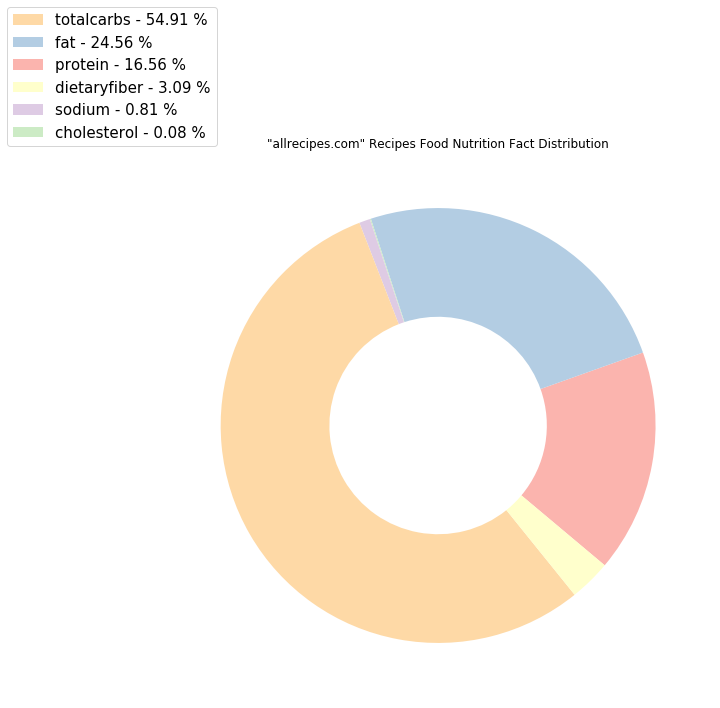

In [55]:
# Donut Plot of food nutrition facts with proportions of each nutrition fact of all repices on allrecipe.com
from palettable.colorbrewer.qualitative import Pastel1_7

fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(aspect="equal"))

names = 'protein', 'fat', 'cholesterol', 'sodium', 'totalcarbs', 'dietaryfiber'
s = nutrition_fact_all_recipe.mean()

percent = 100.*s/s.sum()

patches, texts = plt.pie(s, wedgeprops=dict(width=0.5), startangle=-40, textprops={'fontsize': 14}, colors=Pastel1_7.hex_colors)
labels = ['{0} - {1:1.2f} %'.format(i,j) for i,j in zip(names, percent)]
sort_legend = True

if sort_legend:
    patches, labels, dummy =  zip(*sorted(zip(patches, labels, s),
                                          key=lambda x: x[2],
                                          reverse=True))
plt.legend(patches, labels, loc='lower center', bbox_to_anchor=(-0.1, 1.),
           fontsize=15)

ax.set_title('"allrecipes.com" Recipes Food Nutrition Fact Distribution')

plt.show()

We can see that the highest nutrition component by quantity and on average is Carbohydrates with over 50% of the composition. Fat and protein follow with about 24% and 17% of the total composition respectively. Cholesterol and sodium, as expected, are at the bottom of the chart due to their presence being very low. In fact, for these last two, it is usually measured in milligrams, rather than in grams.

#### Nutrition Items vs Average Grams

Text(0,0.5,'Average Grams')

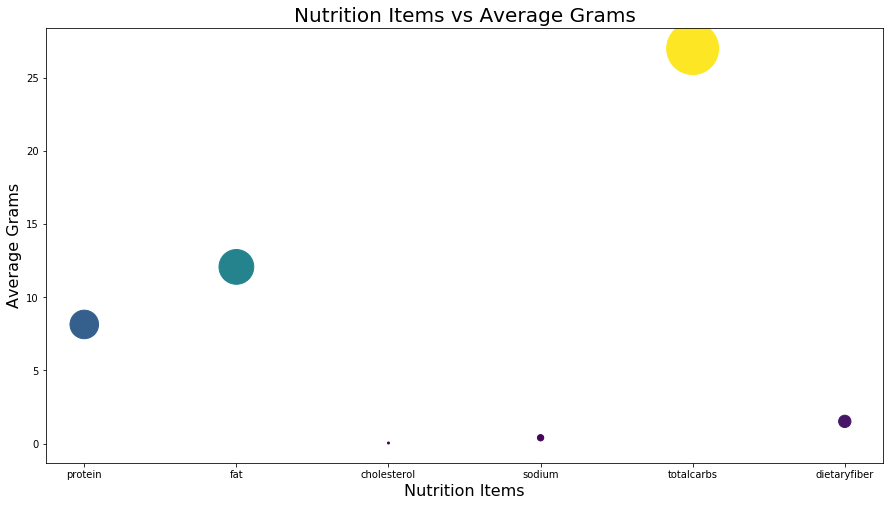

In [56]:
# Scatterplot
#set size of plot
plt.figure(figsize=(15,8))
#create plot
plt.scatter(names, s, s=s*100 , c=s)

#assign labels and title
plt.title('Nutrition Items vs Average Grams', fontsize=20)
plt.xlabel('Nutrition Items', fontsize=16)
plt.ylabel('Average Grams', fontsize=16)

A scatteplot is shown above as another way to visualize the distribution of the nutrition components by showing the average gram quantity in all the recipes.

#### Time vs Ratings

In [63]:
from scipy import stats
# Select only prep and cooking times
prep_time_all_recipe = full_set[['total_time', 'rating']].copy()

# Remove negative and null cols
prep_time_all_recipe = prep_time_all_recipe[~(prep_time_all_recipe < 0)]
prep_time_all_recipe = prep_time_all_recipe.dropna()
prep_time_all_recipe['total_time'] = prep_time_all_recipe['total_time']/60

# Remove outliers with Z-score
numeric_cols = prep_time_all_recipe.select_dtypes(include=[np.number]).columns
z = prep_time_all_recipe[numeric_cols].apply(stats.zscore)

prep_time = prep_time_all_recipe[(z < 3).all(axis=1)]

Text(0,0.5,'Ratings')

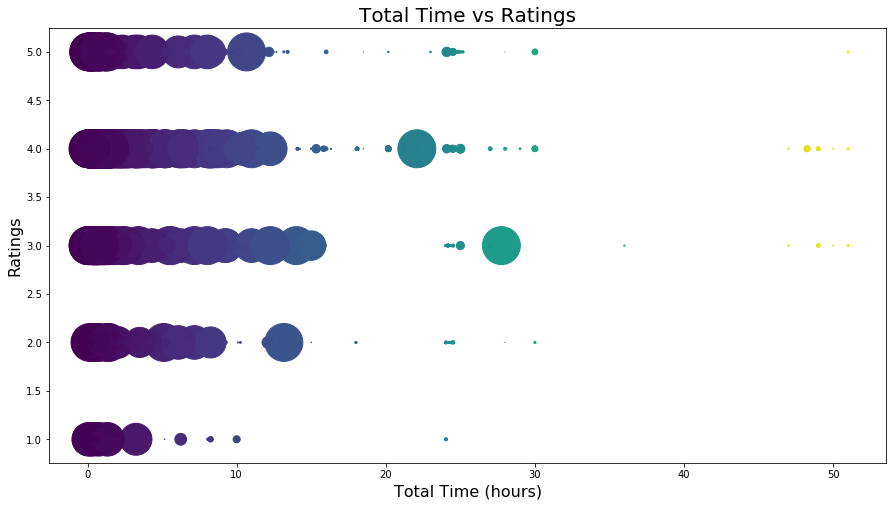

In [64]:
# Scatterplot
plt.figure(figsize=(15,8))
plt.scatter(prep_time['total_time'], prep_time['rating'], s=prep_time['total_time'].value_counts()/10, c=prep_time['total_time'])

#assign labels and title
plt.title('Total Time vs Ratings', fontsize=20)
plt.xlabel('Total Time (hours)', fontsize=16)
plt.ylabel('Ratings', fontsize=16)

<Figure size 1152x576 with 0 Axes>

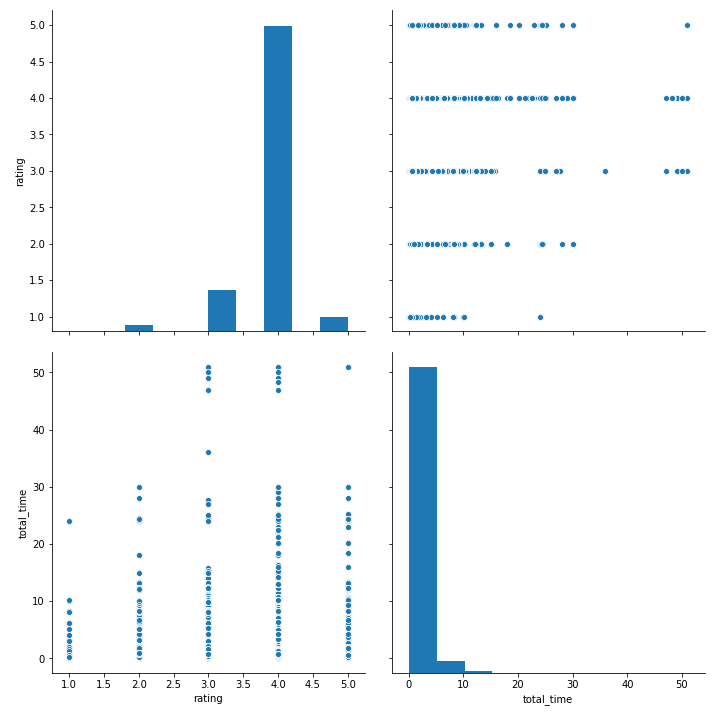

In [65]:
_ = plt.figure(figsize=(16,8))
sns.pairplot(data=prep_time, vars=['rating', 'total_time'], height=5)

In this scatterplot we can see the total time to cook a recipe. We can see from the above graph that there are more recipes with longer times of preparation/cooking with high ratings that there are with lower ratings.

In [140]:
# pearson_corr, _ = pearsonr(full_set_test1['rating'], full_set_test1['total_time'])
# print('Rating vs Prep Time Pearson:', round(pearson_corr,3))

# pearson_corr, _ = pearsonr(full_set_test1['rating'], full_set_test1['servings'])
# print('Rating vs Servings Pearson:', round(pearson_corr,3))

# pearson_corr, _ = pearsonr(full_set_test1['rating'], full_set_test1['year'])
# print('Rating vs Years Pearson:', round(pearson_corr,3))

pearson_corr, _ = pearsonr(full_set_test1['rating'], full_set_test1['protein'])
print('Rating vs Protein:', round(pearson_corr,3))

pearson_corr, _ = pearsonr(full_set_test1['rating'], full_set_test1['fat'])
print('Rating vs Fat:', round(pearson_corr,3))

pearson_corr, _ = pearsonr(full_set_test1['rating'], full_set_test1['cholesterol'])
print('Rating vs Cholesterol:', round(pearson_corr,3))

pearson_corr, _ = pearsonr(full_set_test1['rating'], full_set_test1['sodium'])
print('Rating vs Sodium:', round(pearson_corr,3))

pearson_corr, _ = pearsonr(full_set_test1['rating'], full_set_test1['totalcarbs'])
print('Rating vs Carbs:', round(pearson_corr,3))

pearson_corr, _ = pearsonr(full_set_test1['rating'], full_set_test1['fiber'])
print('Rating vs Fiber:', round(pearson_corr,3))

Rating vs Protein: 0.005
Rating vs Fat: 0.018
Rating vs Cholesterol: 0.01
Rating vs Sodium: 0.002
Rating vs Carbs: 0.011
Rating vs Fiber: -0.002


In [92]:
full_set_test1

,protein,fat,cholesterol,sodium,totalcarbs,fiber
name,,,,,,
""" Ant"" Kelly's London Broil Marinade",2.7,18.0,0.0,1457.3,7.9,0.3
""" Creamy "" Vegan Potato-Leek Soup",6.5,2.0,0.0,18.0,35.9,5.5
""" Da Best"" Chicago-Style Italian Beef",67.7,39.5,243.1,517.7,3.2,0.4
""" Healthy"" Pumpkin Pie",3.9,0.1,0.5,51.6,5.1,0.2
""" Jamba Juice at Home"" Strawberries Wild Smoothie",0.6,0.3,0.0,4.0,19.0,1.6
""" Pink Stuff "" ( Cherry Pie Filling, Pineapple Dessert",4.0,12.2,13.5,70.2,55.0,0.8
""" Splenda "" D Cheesecake Sugar-Free Low-Carb",10.9,52.0,203.3,352.4,14.9,1.0
"""Cream"" of Cauliflower Soup (Vegan)",7.8,2.9,0.0,45.9,32.0,8.2
"""Diet"" Cake",2.0,4.9,26.4,200.7,22.6,0.2


#### Serving size vs Ratings

In [66]:
all_recipe_servings = full_set[['rating', 'servings']].copy()
all_recipe_servings.head()

,rating,servings
0,4,12.0
1,4,12.0
10,4,12.0
100,4,16.0
1000,4,16.0


Text(0,0.5,' Ratings')

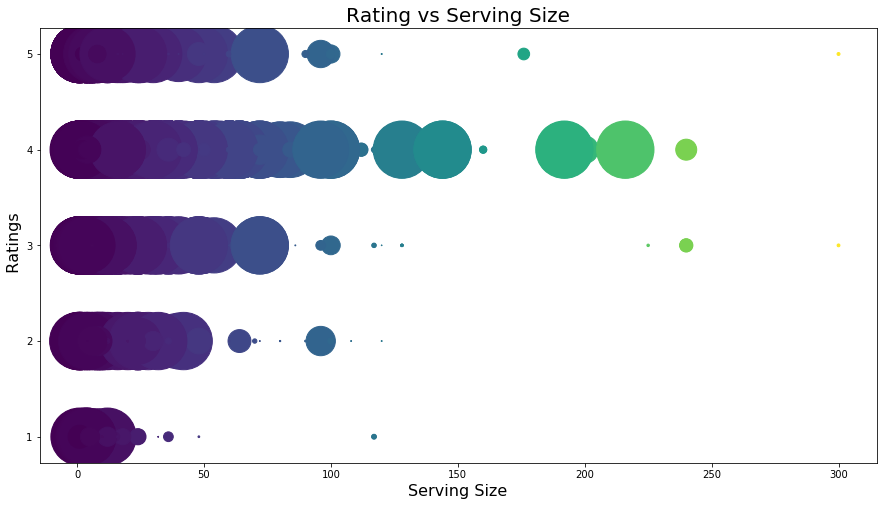

In [67]:
# Scatterplot
plt.figure(figsize=(15,8))
plt.scatter(all_recipe_servings['servings'], all_recipe_servings['rating'], s=all_recipe_servings['servings'].value_counts()/10, c=all_recipe_servings['servings'])

#assign labels and title
plt.title('Rating vs Serving Size', fontsize=20)
plt.xlabel('Serving Size', fontsize=16)
plt.ylabel(' Ratings', fontsize=16)

By plotting the ratings vs the serving size we can notice that the lower the rating the smaller is the range of serving portions. The recipes with 4 ratings show an intense density until around 85 serving portions. These portions are quite large and it can be taken as more valuable due to the greater number of people that possibly tasted the food and liked it.

#### Years vs Ratings

In [53]:
all_recipe_years = full_set[['rating', 'year']].copy()
all_recipe_years.head()

,rating,year
0,4,2005
10,4,2006
100,4,2004
1000,4,2003
10000,4,2004


Text(0,0.5,'Year')

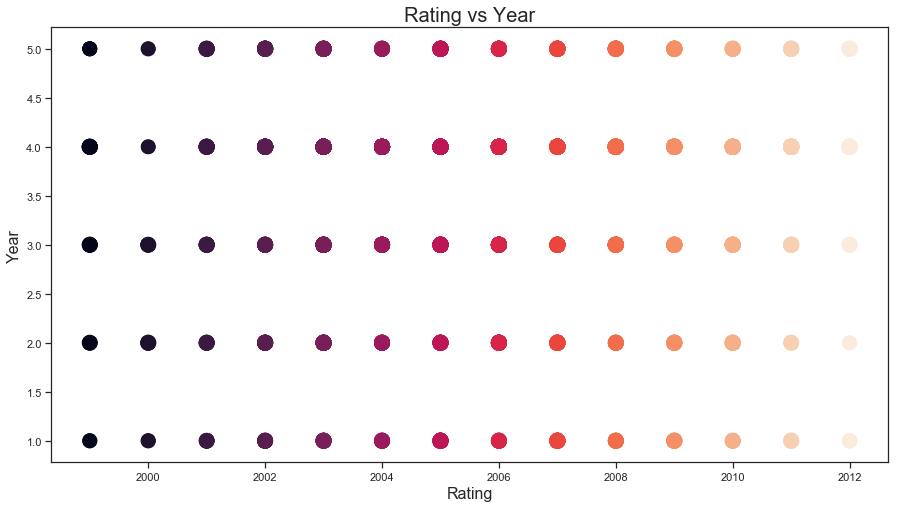

In [54]:
# Scatterplot
plt.figure(figsize=(15,8))
plt.scatter(all_recipe_years['year'], all_recipe_years['rating'], s=all_recipe_years['year'].value_counts()/10, c=all_recipe_years['year'])

#assign labels and title
plt.title('Rating vs Year', fontsize=20)
plt.xlabel('Rating', fontsize=16)
plt.ylabel('Year', fontsize=16)

From the above graph we can see that the distribution between ratings and years of the recipes is quite consistent throughout the years. 